## Final Project Submission

Please fill out:
* Student name: Phillip Ojo
* Student pace: Part time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:


## Introduction

The global video streaming market size was pegged at USD 42.6 billion in 2019 and is expected to register a CAGR of 20.4% from 2020 to 2027. In the recent past, the popularity of such platforms over broadcast media such as YouTube and Netflix has increased considerably. Netflix (NFLX) is the dominant company in the on-demand media industry, with 167 million paying subscribers around the world. Fast-forward to today, Microsoft sees all the big companies creating original video content, and they want to get in on the fun. In this excersise, we will analyze the current movie industry and take those findings and turn them into actionable insights that the CEO can use when deciding what type of films they should be creating.  



In [33]:
# Your code here - remember to use markdown cells for comments as well!
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [34]:
#Webscrapping TMDB website
!pip install fake_useragent
!pip install lxml
import fake_useragent
import lxml
from bs4 import BeautifulSoup
import requests

tmdb_webpage = 'https://www.themoviedb.org/movie/top-rated?page=0' 


## Data Harvesting

We extracted data from TMDB website.

```python
#Check connection

response = requests.get(url= tmdb_webpage, timeout=3)
print('Status Code:', response.status_code)
if response.status_code == 200:
    print('Connection successfull.\n\n')
else:
    print('Error. Check Status code table.\n\n')

page_content = response.content
soup = BeautifulSoup(page_content, 'html.parser') 
```

```python
#Function to load all the pages and scrap the data

def next_page(base_url):
    new_page_num = int(base_url.split('=')[-1]) +1
    base_url = base_url.split('=')[0] + '=' + str(new_page_num)
    return (base_url)

next_page(tmdb_webpage)
```

```python
#Function to Scrape all of the Movies on the Given Movies Page
def scrape_movies_list(base_url):
    html_page = requests.get(base_url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    base_movie_url = 'https://www.themoviedb.org/'
    movies_data = soup.find('section', id='media_results')
    movie_entries = movies_data.findAll('a', class_='image')
    movie_titles = []
    movie_pages = []
    df_list = []
    for entry in movie_entries:    
        title = entry.get('title')
        ext_1 = entry.get('href').split('/movie/')
        ext_2 = title.replace(' ','-').replace('/','-')
        url = base_movie_url+'movie/'+ext_1[1]+'-'+ext_2
        movie_titles.append(title)
        movie_pages.append(url)
    for movie in movie_pages:
        time.sleep(.2)
        html_page_2 = requests.get(movie)
        soup_2 = BeautifulSoup(html_page_2.content, 'html.parser')
        html_page_3 = requests.get(movie+'/cast')
        soup_3 = BeautifulSoup(html_page_3.content, 'html.parser')
        specific_movie_data_1 = soup_2.find('div', class_='single_column')
        title = specific_movie_data_1.find('h2').text.split('(')[0].strip()
        
        #GETTING MOVIE TITLE
        specific_movie_data_1 = soup_2.find('div', class_='single_column')
        try:
            title = specific_movie_data_1.find('h2').text.split('(')[0].strip()
            
        except:
            title = None
            
        #GETTING RELEASE DATE
        try:
            release_date = specific_movie_data_1.find('span',class_='release').text.strip().split('(')[0]
            
        except:
            release_date = None            

        #GETTING GENRE LIST
        try:
            genre_list = []
            for genre in specific_movie_data_1.find('span',class_='genres').findAll('a'):
                genre_list.append(genre.text)
            
        except:
            genre_list = None
            
        #GETTING LENGTH OF MOVIE
        try:
            run_time = specific_movie_data_1.find('span',class_='runtime').text.strip()
            
        except:
            run_time = None
            
        #GETTING MOVIE CERTIFICATION
        try:
            certification = specific_movie_data_1.find('span',class_='certification').text.strip()
        
        except:
            certification = None
            
        #GETTING AVERAGE MOVIE RATING
        try:
            user_score = specific_movie_data_1.find('div',class_='percent').find('span').get('class')[1].split('-r')[-1]
            
        except:
            user_score = None
            
        #GETTING LANGUAGE, BUDGET, AND REVENUE FROM FACTS LEFT_COLUMN
        specific_movie_data_2 = soup_2.find('section', class_='facts left_column')
        for data in specific_movie_data_2.findAll('p'):
            if data.text.split()[1] == 'Language':
                original_language = data.text.split()[-1]
                
            #USED NESTED IF STATEMENTS BECAUSE SOME MOVIES DON'T HAVE BUDGET OR REVENUE DATA
            elif data.text.split()[0] == 'Budget':
                if data.text.split()[-1] == '-':
                    movie_budget = None
                    
                else:
                    movie_budget = int(data.text.split()[-1].strip('$').replace(',','').replace('.00',''))
                    
            elif data.text.split()[0] == 'Revenue':
                if data.text.split()[-1] == '-':
                    movie_revenue = None
                    
                else:        
                    movie_revenue = int(data.text.split()[-1].strip('$').replace(',','').replace('.00',''))
                    
        #GETTING MOVIE KEYWORDS
        specific_movie_data_3 = soup_2.find('section',class_='keywords right_column')
        keyword_list = []
        for keyword in specific_movie_data_3.findAll('a'):
            keyword_list.append(keyword.text)
        

        #GETTING LIST OF ACTORS
        specific_movie_data_4 = soup_2.find('ol',class_='people scroller')
        actors_list = []
        #USED TRY BECAUSE SOME PAGES ARE MISSING ACTORS DATA
        try:
            for actor in specific_movie_data_4.findAll('p'):
                if actor.find('a') != None:
                    if actor.find('a').text != 'View More ':
                        actors_list.append(actor.find('a').text)
            
        except:
            actors_list.append(None)
            

         #GETTING DIRECTOR'S NAME
        try:
            specific_movie_data_5 = soup_3.findAll('section',class_='panel pad')[1]
            #print(specific_movie_data_5)
            count = 0
            crew_list = []
            director_list = []
            for crew_member in specific_movie_data_5.findAll('p'):
                count += 1
                crew_list.append(crew_member)
                if crew_member.text.strip() == 'Director':
                    director_position = count-2
                    director = crew_list[director_position].text
                    director_list.append(director)
            
        except:
            director_list = None
            
        #MAKING THE DATAFRAME
        tmdb_df = pd.DataFrame([title,release_date,genre_list,run_time,certification,user_score,original_language,movie_budget,movie_revenue,keyword_list,actors_list,director_list]).transpose()
        tmdb_df.columns = ['title','release_date','genre','run_time','certification','user_score','original_language','movie_budget','movie_revenue','keywords','actors','director_list']
        df_list.append(df)
        tmdb_df = pd.concat(df_list)
    return(df)


tmdb_df.to_csv('tmdb_webscraping.csv')

```

Manipulating the dataset

In [35]:
tmdb_df = pd.read_csv('tmdb_webscraping.csv')
tmdb_df.head()

,£,title,release_date,genre,run_time,certification,user_score,original_language,movie_budget,movie_revenue,keywords,actors,director_list
0,0,Dilwale Dulhania Le Jayenge,10/20/1995,"['Comedy', 'Drama', 'Romance']",3h 10m,U,88,Hindi,13200000.0,100000000.0,[],"['Shah Rukh Khan', 'Kajol', 'Amrish Puri', 'An...",['Aditya Chopra']
1,0,The Shawshank Redemption,10/14/1994,"['Drama', 'Crime']",2h 22m,R,87,English,25000000.0,28341469.0,"['prison', 'corruption', 'police brutality', '...","['Tim Robbins', 'Morgan Freeman', 'Bob Gunton'...",['Frank Darabont']
2,0,The Godfather,03/15/1972,"['Drama', 'Crime']",2h 55m,R,87,English,6000000.0,245066411.0,"['italy', 'loss of loved one', 'love at first ...","['Marlon Brando', 'Al Pacino', 'James Caan', '...",['Francis Ford Coppola']
3,0,Schindler's List,02/04/1994,"['Drama', 'History', 'War']",3h 15m,R,86,English,22000000.0,321365567.0,"['based on novel or book', 'factory', 'concent...","['Liam Neeson', 'Ben Kingsley', 'Ralph Fiennes...",['Steven Spielberg']
4,0,Your Name.,08/26/2016,"['Romance', 'Animation', 'Drama']",1h 46m,PG,86,Japanese,NaN,357986087.0,"['time travel', 'supernatural', 'afterlife', '...","['Ryunosuke Kamiki', 'Mone Kamishiraishi', 'Ma...",['Makoto Shinkai']


In [36]:
tmdb_df.sort_values(by = 'movie_revenue', ascending= False, inplace = True)
tmdb_df.head()

,£,title,release_date,genre,run_time,certification,user_score,original_language,movie_budget,movie_revenue,keywords,actors,director_list
70,0,Avengers: Endgame,04/26/2019,"['Adventure', 'Science Fiction', 'Action']",3h 1m,PG-13,83,English,356000000.0,2.797801e+09,"['space travel', 'time travel', 'time machine'...","['Robert Downey Jr.', 'Chris Evans', 'Mark Ruf...","['Anthony Russo', 'Joe Russo']"
986,0,Avatar,12/18/2009,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",2h 42m,PG-13,74,English,237000000.0,2.787965e+09,"['culture clash', 'future', 'space war', 'spac...","['Sam Worthington', 'Zoe Saldana', 'Stephen La...",['James Cameron']
1114,0,Star Wars: The Force Awakens,12/18/2015,"['Action', 'Adventure', 'Science Fiction', 'Fa...",2h 16m,PG-13,74,English,245000000.0,2.068224e+09,"['android', 'spacecraft', 'jedi', 'imax', 'spa...","['Harrison Ford', 'Mark Hamill', 'Carrie Fishe...",['J.J. Abrams']
81,0,Avengers: Infinity War,04/27/2018,"['Adventure', 'Action', 'Science Fiction']",2h 29m,PG-13,83,English,300000000.0,2.046240e+09,"['magic', 'sacrifice', 'superhero', 'based on ...","['Robert Downey Jr.', 'Chris Hemsworth', 'Chri...","['Joe Russo', 'Anthony Russo']"
387,0,Titanic,12/19/1997,"['Drama', 'Romance']",3h 14m,PG-13,78,English,200000000.0,1.845034e+09,"['iceberg', 'ship', 'panic', 'titanic', 'ocean...","['Leonardo DiCaprio', 'Kate Winslet', 'Billy Z...",['James Cameron']


##  Question #1 

> We want to take a look at which movie rating category would be ideal to pursue. Compare the movie rating categories vs the total movie revenue for all the titles.

In [37]:
#Filter Rows by movie bu rated R
tmdb_df1 = tmdb_df[(tmdb_df.certification == "R") & (tmdb_df.user_score >= 70 ) ]


The dataset comes with alot of diffrent movie rating. This can present an issue when ploting so what we want to do is find all the unique values through out the ratings column. Once we get all the unique values we want to take out all the popular ones and group the reminaning ratings as "MISC". 

In [38]:
#Find all the diffrent types of movie rating.
tmdb_df['certification'].unique() #Gives us all the unique movie ratings

array(['PG-13', 'PG', 'R', 'G', 'UA', 'NR', 'U', '12세 이상 관람가',
       '15세 이상 관람가', '12', '7', '12A', 'T', '16', '15', 'TP', 'M',
       '청소년 관람불가', 'NC-17', '18', nan, '12+', 'R18+', 'Btl', '14 Anos',
       'Livre', 'AL', '6', '11', 'MA15+', 'VM14', '18+', '14', 'R-15',
       '13', 'B', 'L', '16+', '전체관람가', 'e 10', '0', 'VM18', '0+', 'M/12',
       'e Livre', 'R15+', '14A', 'M/14', 'APTA', 'M18', 'A', 'PG-12',
       '10', 'KN', 'PG13', '13+', 'R21', 'NC16'], dtype=object)

In [39]:
Null_rankings= ['14','12','G','nan','16','15','MA15+','6','12A','12+','T','18+','L','VM14','Livre','0+','15세 이상 관람가','0','AL','M/12','12세 이상 관람가','NC-17','18','전체관람가', 'e Livre', '청소년 관람불가','e 10','11','16+','13','R15+','M','14A','M/14','APTA','7','B','VM18','UA','R-15','Btl','M18','A','TP','PG-12','10','R18+','14 Anos', 'KN','PG13','13+','R21','NC16']

tmdb_df['certification'].replace( Null_rankings, 'MISC' , inplace = True)
tmdb_df['certification'].unique()

array(['PG-13', 'PG', 'R', 'MISC', 'NR', 'U', nan], dtype=object)

Now we want to graph the relationship between movie ratings and movie revenue in each category

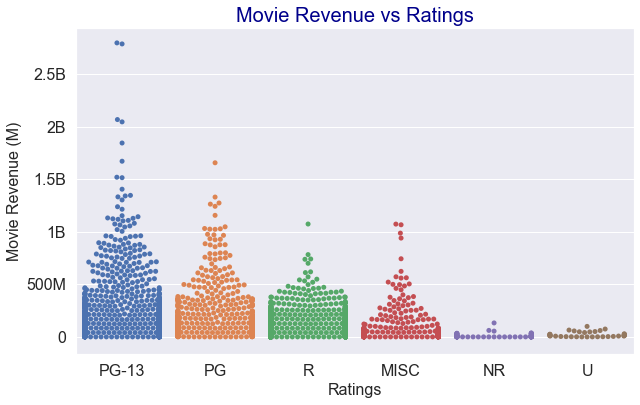

In [40]:
import matplotlib.ticker as tick
fig_dims = (10,6)
fig, ax = plt.subplots(figsize = fig_dims)

sns.set_style('darkgrid')
sns.set(font_scale =1.6)

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format
ax = sns.swarmplot(data = tmdb_df, x= 'certification', y ='movie_revenue')
plt.title('Movie Revenue vs Ratings' , fontsize = 20, color = 'darkblue')
ax.set_ylabel("Movie Revenue (M)")
ax.set_xlabel("Ratings")
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

#Set fonts to consistent 16pt size
for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

Now lets look at the average revenue/budget for each movie rating category.

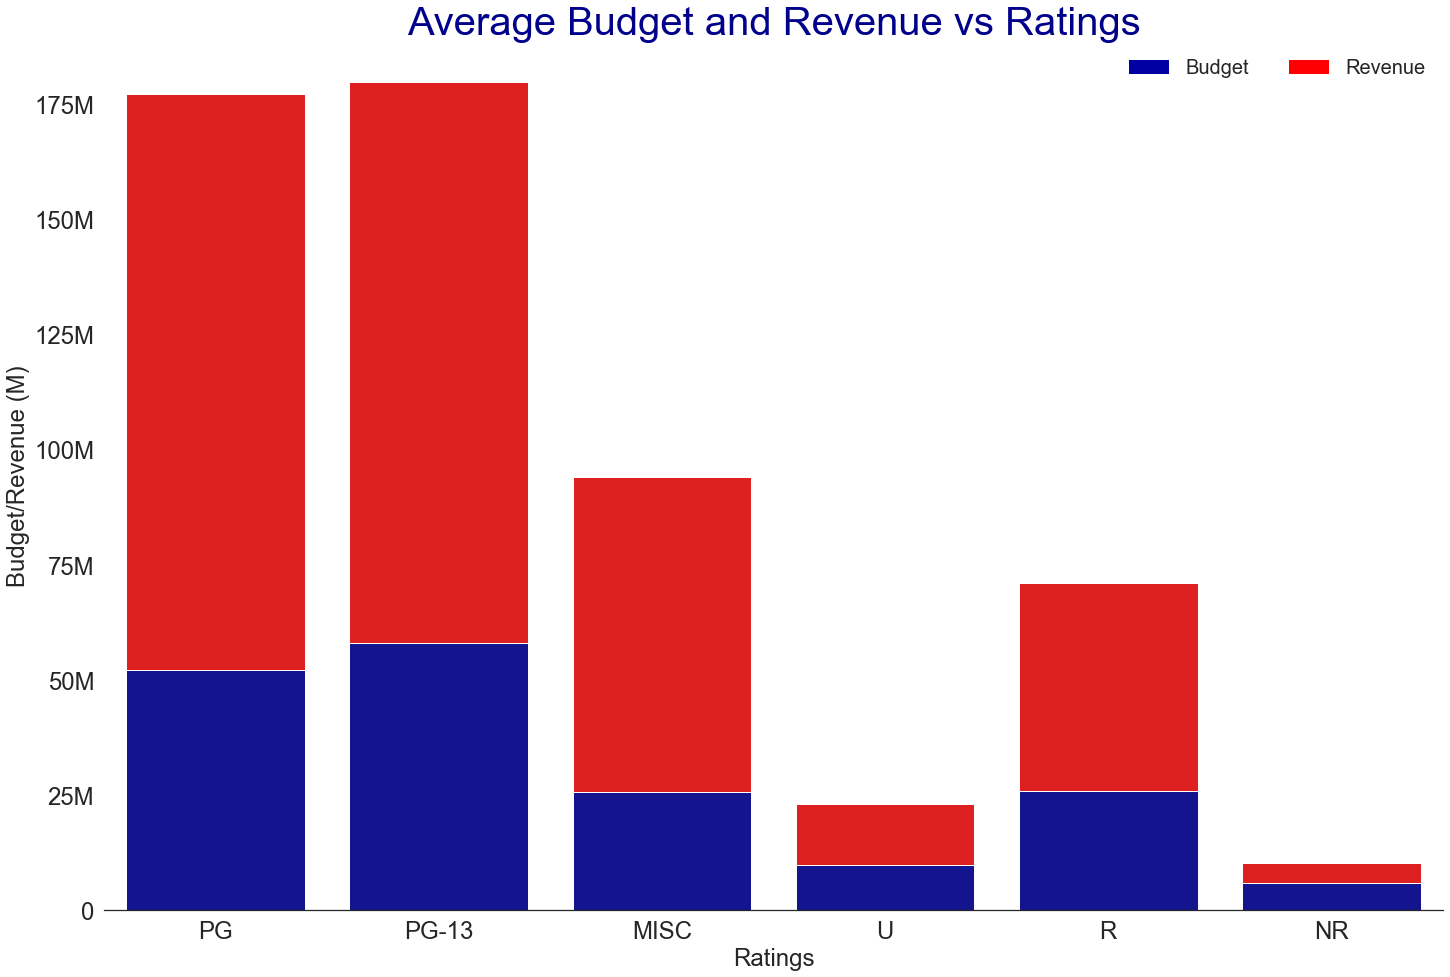

In [41]:
#Average Revenue Data

U_rev_df = tmdb_df[tmdb_df['certification'] == 'U']
U_rev_mean = round(U_rev_df['movie_revenue'].mean(),0)
R_rev_df = tmdb_df[tmdb_df['certification'] == 'R']
R_rev_mean = round(R_rev_df['movie_revenue'].mean(),0)
PG_rev_df = tmdb_df[tmdb_df['certification'] == 'PG']
PG_rev_mean = round(PG_rev_df['movie_revenue'].mean(),0)
PG13_rev_df = tmdb_df[tmdb_df['certification'] == 'PG-13']
PG13_rev_mean = round(PG13_rev_df['movie_revenue'].mean(),0)
MISC_rev_df = tmdb_df[tmdb_df['certification'] == 'MISC']
MISC_rev_mean = round(MISC_rev_df['movie_revenue'].mean(),0)
NR_rev_df = tmdb_df[tmdb_df['certification'] == 'NR']
NR_rev_mean = round(NR_rev_df['movie_revenue'].mean(),0)


#Average budget Data
U_budg_df = tmdb_df[tmdb_df['certification'] == 'U']
U_budg_mean = round(U_budg_df['movie_budget'].mean(),0)
R_budg_df = tmdb_df[tmdb_df['certification'] == 'R']
R_budg_mean = round(R_budg_df['movie_budget'].mean(),0)
PG_budg_df = tmdb_df[tmdb_df['certification'] == 'PG']
PG_budg_mean = round(PG_budg_df['movie_budget'].mean(),0)
PG13_budg_df = tmdb_df[tmdb_df['certification'] == 'PG-13']
PG13_budg_mean = round(PG13_budg_df['movie_budget'].mean(),0)
MISC_budg_df = tmdb_df[tmdb_df['certification'] == 'MISC']
MISC_budg_mean = round(MISC_budg_df['movie_budget'].mean(),0)
NR_budg_df = tmdb_df[tmdb_df['certification'] == 'NR']
NR_budg_mean = round(NR_budg_df['movie_budget'].mean(),0)

Buget = [PG_budg_mean,PG13_budg_mean, MISC_budg_mean,U_budg_mean, R_budg_mean,   NR_budg_mean]
Revenue = [PG_rev_mean,PG13_rev_mean, MISC_rev_mean,U_rev_mean, R_rev_mean,   NR_rev_mean]

Ratings = ["PG","PG-13","MISC","U","R","NR"]

#Set general plot properties
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 16)})


#Plot 1 - background - "total" (top) series
sns.barplot(x = Ratings, y = Revenue, color = "red")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = Ratings, y = Buget, color = "#0000A3")


topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Budget', 'Revenue'], loc=1, ncol = 2, prop={'size':20})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Budget/Revenue (M)")
bottom_plot.set_xlabel("Ratings")
plt.title('Average Budget and Revenue vs Ratings' , fontsize = 40, color = 'darkblue')

# Get, set, and format y-axis Price labels

bottom_plot.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

#Set fonts to consistent 16pt size
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(24)

### Answer 1

- Looking at the two graphs above, We see that the favorable movie rating categories we should pursue are PG/PG-13. 

- This in facts make a lot of sense because with this movie rating, you are able to reach a wider audience from kids to adults which in turn generates more revenue. 



## Questions 2:

> **Now we want to compare the reveune of the diffrent movie rating categories in the last five decades.**

In [42]:
tmdb_df.dtypes

£                      int64
title                 object
release_date          object
genre                 object
run_time              object
certification         object
user_score             int64
original_language     object
movie_budget         float64
movie_revenue        float64
keywords              object
actors                object
director_list         object
dtype: object

In [43]:
#Changing the str format of the date to a Datetime format
tmdb_df['release_date'] = tmdb_df.release_date.str.replace(' ', '')

In [44]:
tmdb_df.loc[0, 'release_date']



'10/20/1995'

In [45]:
tmdb_df['release_date'] = pd.to_datetime(tmdb_df['release_date'], format = '%m/%d/%Y')

tmdb_df.dtypes

£                             int64
title                        object
release_date         datetime64[ns]
genre                        object
run_time                     object
certification                object
user_score                    int64
original_language            object
movie_budget                float64
movie_revenue               float64
keywords                     object
actors                       object
director_list                object
dtype: object

In [46]:
#Now lets filter out the years by Decade. 70s-80s, 80s-90s, 90s-00s, 00s-10s, 10s-20s

tmdb_df['release_date'] = tmdb_df.release_date.dt.year
tmdb_df.head()

,£,title,release_date,genre,run_time,certification,user_score,original_language,movie_budget,movie_revenue,keywords,actors,director_list
70,0,Avengers: Endgame,2019,"['Adventure', 'Science Fiction', 'Action']",3h 1m,PG-13,83,English,356000000.0,2.797801e+09,"['space travel', 'time travel', 'time machine'...","['Robert Downey Jr.', 'Chris Evans', 'Mark Ruf...","['Anthony Russo', 'Joe Russo']"
986,0,Avatar,2009,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",2h 42m,PG-13,74,English,237000000.0,2.787965e+09,"['culture clash', 'future', 'space war', 'spac...","['Sam Worthington', 'Zoe Saldana', 'Stephen La...",['James Cameron']
1114,0,Star Wars: The Force Awakens,2015,"['Action', 'Adventure', 'Science Fiction', 'Fa...",2h 16m,PG-13,74,English,245000000.0,2.068224e+09,"['android', 'spacecraft', 'jedi', 'imax', 'spa...","['Harrison Ford', 'Mark Hamill', 'Carrie Fishe...",['J.J. Abrams']
81,0,Avengers: Infinity War,2018,"['Adventure', 'Action', 'Science Fiction']",2h 29m,PG-13,83,English,300000000.0,2.046240e+09,"['magic', 'sacrifice', 'superhero', 'based on ...","['Robert Downey Jr.', 'Chris Hemsworth', 'Chri...","['Joe Russo', 'Anthony Russo']"
387,0,Titanic,1997,"['Drama', 'Romance']",3h 14m,PG-13,78,English,200000000.0,1.845034e+09,"['iceberg', 'ship', 'panic', 'titanic', 'ocean...","['Leonardo DiCaprio', 'Kate Winslet', 'Billy Z...",['James Cameron']


In [47]:
#Create Decades

decade1 = 1970
decade2 = 1980
decade3 = 1990
decade4 = 2000
decade5 = 2010
decade6 = 2020

In [48]:
decade1_df = tmdb_df[tmdb_df.release_date.between(decade1,decade2)]
print(len(decade1_df),   'movies in 70s')

decade2_df = tmdb_df[tmdb_df.release_date.between(decade2,decade3)]
print(len(decade2_df), 'movies in 80s')

decade3_df = tmdb_df[tmdb_df.release_date.between(decade3,decade4)]
print(len(decade3_df), 'movies in 90s')

decade4_df = tmdb_df[tmdb_df.release_date.between(decade4,decade5)]
print(len(decade4_df), 'movies in 00s')

decade5_df = tmdb_df[tmdb_df.release_date.between(decade5,decade6)]
print(len(decade5_df), 'movies in 10s')

201 movies in 70s
441 movies in 80s
875 movies in 90s
1843 movies in 00s
2594 movies in 10s


In [49]:
decade1_df['DECADE'] = '1970'
decade2_df['DECADE'] = '1980'
decade3_df['DECADE'] = '1990'
decade4_df['DECADE'] = '2000'
decade5_df['DECADE'] = '2010'


In [50]:
com_decade = pd.concat([decade1_df,decade2_df,decade3_df,decade4_df,decade5_df])

Text(0.5, 1.0, 'Movies in the last five decades (Ratings vs Revenue)')

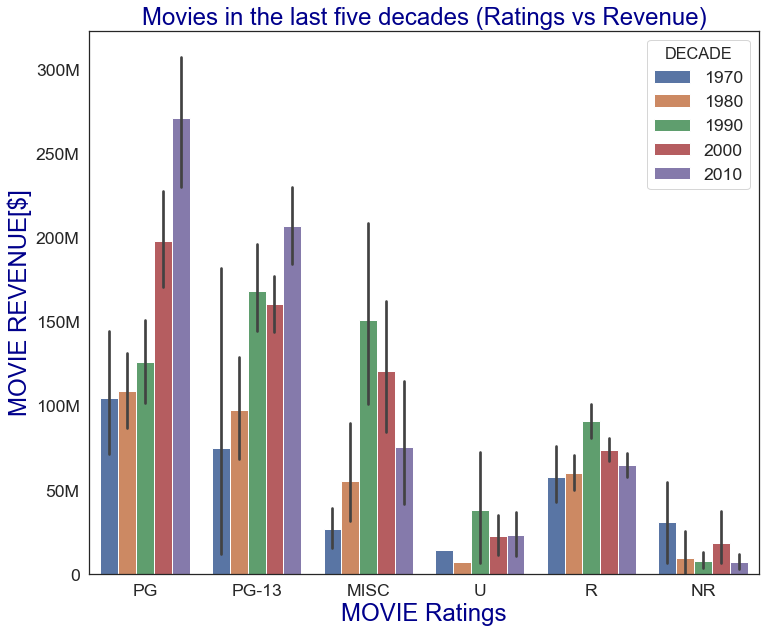

In [62]:

ax = sns.barplot(data= com_decade, hue= 'DECADE', x= 'certification', y ='movie_revenue', order = Ratings)
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
ax.set_ylabel('MOVIE REVENUE[$]',fontsize=24, color = 'darkblue')
ax.set_xlabel('MOVIE Ratings',fontsize=24, color = 'darkblue')
ax.set_title('Movies in the last five decades (Ratings vs Revenue)' , fontsize = 24, color = 'darkblue')


## Answer #2

> Although viewing restriction has have loosened  PG/PG-13 is the way to go still due to its wide audience. They usually require a licence to a character or specific story. Rated R movies did not stand a chance over the last four decades. However, we may see a rise in viewership from the Rated R and NR categories due to the loosened censorship that we are experienceing in media currently.

## Question 3

> **Now lastly we will look at the relationship between each Genere movie budget and revenue over the last four decades to see if anything stands out.**


In [52]:
#Make list of data frames
df_list = [decade1_df,decade2_df,decade3_df,decade4_df,decade5_df]

In [53]:
new_decade_data =[]
for df in df_list:
        df['genre_explode'] = df.genre.map(lambda x: x.replace("[", "").replace("]", "").replace(" ", "").split(","))

        df =df.explode('genre_explode')
        df = df.groupby('genre_explode', as_index = False)['movie_budget', 'movie_revenue'].aggregate('mean')
        display (df.head())

        new_decade_data.append(df)

,genre_explode,movie_budget,movie_revenue
0,'Action',9.597812e+06,1.193068e+08
1,'Adventure',1.075145e+07,1.392757e+08
2,'Animation',5.866667e+06,3.862656e+07
3,'Comedy',6.686355e+06,5.813325e+07
4,'Crime',5.522083e+06,4.766851e+07


,genre_explode,movie_budget,movie_revenue
0,'Action',2.220819e+07,1.065343e+08
1,'Adventure',2.377432e+07,1.235940e+08
2,'Animation',1.809947e+07,7.252705e+07
3,'Comedy',1.657082e+07,8.757618e+07
4,'Crime',1.869252e+07,7.005867e+07


,genre_explode,movie_budget,movie_revenue
0,'Action',5.390852e+07,1.461017e+08
1,'Adventure',5.622087e+07,1.670934e+08
2,'Animation',5.301502e+07,1.645689e+08
3,'Comedy',3.553257e+07,1.147041e+08
4,'Crime',3.280267e+07,9.631856e+07


,genre_explode,movie_budget,movie_revenue
0,'Action',6.626777e+07,1.719598e+08
1,'Adventure',8.120081e+07,2.473584e+08
2,'Animation',7.710425e+07,2.452377e+08
3,'Comedy',4.282838e+07,1.183142e+08
4,'Crime',3.826511e+07,8.993223e+07


,genre_explode,movie_budget,movie_revenue
0,'Action',7.418891e+07,2.448975e+08
1,'Adventure',1.067692e+08,3.767778e+08
2,'Animation',8.325757e+07,2.954113e+08
3,'Comedy',4.215602e+07,1.318299e+08
4,'Crime',3.450380e+07,8.569312e+07


In [54]:
new_decade_data[0].shape


(18, 3)

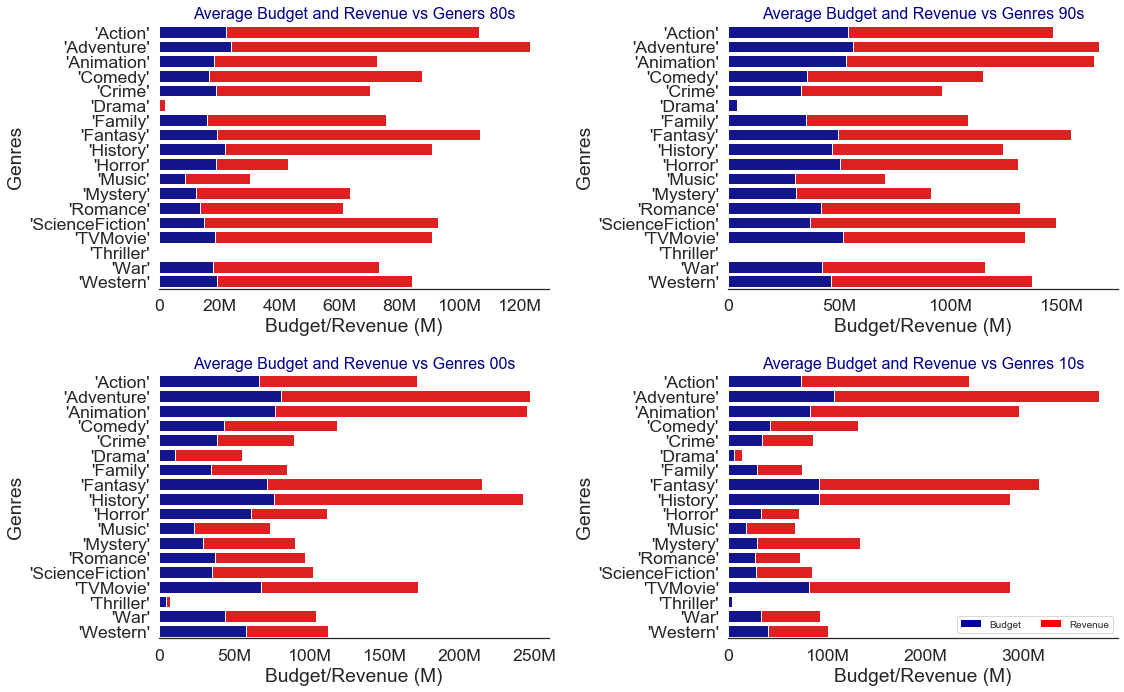

In [55]:

#Set general plot properties
fig, ax = plt.subplots(figsize=(16,10), ncols=2, nrows=2)
sns.set_style("white")
sns.set_context({"figure.figsize": (12, 10)})
i,j = 0, 0

#Plot 1 - background - "total" (top) series

sns.barplot(x=  new_decade_data[1]['movie_revenue'], y= new_decade_data[0]['genre_explode'], color = "red", ax = ax[i,j])
 
#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = new_decade_data[1]['movie_budget'], y= new_decade_data[0]['genre_explode'], color = "#0000A3", ax = ax[i,j])
bottom_plot.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
# bottom_plot.set_xticklabels(bottom_plot.get_xticklabels(),rotation=45)
topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
plt.legend([bottombar, topbar], ['Budget', 'Revenue'], loc=4, ncol = 2, prop={'size':10})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_xlabel("Budget/Revenue (M)")
bottom_plot.set_ylabel("Genres")
ax[i,j].set_title('Average Budget and Revenue vs Geners 80s' , fontsize = 16, color = 'darkblue')

#---------------------------------------------------------------------


i,j = 0, 1

#Plot 1 - background - "total" (top) series

sns.barplot(x=  new_decade_data[2]['movie_revenue'], y= new_decade_data[0]['genre_explode'], color = "red", ax = ax[i,j])
 
#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = new_decade_data[2]['movie_budget'], y= new_decade_data[0]['genre_explode'], color = "#0000A3", ax = ax[i,j])
bottom_plot.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
# bottom_plot.set_xticklabels(bottom_plot.get_xticklabels(),rotation=45)
topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
plt.legend([bottombar, topbar], ['Budget', 'Revenue'], loc=4, ncol = 2, prop={'size':10})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_xlabel("Budget/Revenue (M)")
bottom_plot.set_ylabel("Genres")
ax[i,j].set_title('Average Budget and Revenue vs Genres 90s' , fontsize = 16, color = 'darkblue')

#---------------------------------------------------------------------

i,j = 1, 0

#Plot 1 - background - "total" (top) series

sns.barplot(x=  new_decade_data[3]['movie_revenue'], y= new_decade_data[0]['genre_explode'], color = "red", ax = ax[i,j])
 
#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = new_decade_data[3]['movie_budget'], y= new_decade_data[0]['genre_explode'], color = "#0000A3", ax = ax[i,j])
bottom_plot.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
# bottom_plot.set_xticklabels(bottom_plot.get_xticklabels(),rotation=45)
topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
plt.legend([bottombar, topbar], ['Budget', 'Revenue'], loc=4, ncol = 2, prop={'size':10})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_xlabel("Budget/Revenue (M)")
bottom_plot.set_ylabel("Genres")
ax[i,j].set_title('Average Budget and Revenue vs Genres 00s' , fontsize = 16, color = 'darkblue')


#---------------------------------------------------------------------


i,j = 1, 1

#Plot 1 - background - "total" (top) series

sns.barplot(x=  new_decade_data[4]['movie_revenue'], y= new_decade_data[0]['genre_explode'], color = "red", ax = ax[i,j])
 
#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = new_decade_data[4]['movie_budget'], y= new_decade_data[0]['genre_explode'], color = "#0000A3", ax = ax[i,j])
bottom_plot.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
# bottom_plot.set_xticklabels(bottom_plot.get_xticklabels(),rotation=45)
topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
plt.legend([bottombar, topbar], ['Budget', 'Revenue'], loc=4, ncol = 2, prop={'size':10})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_xlabel("Budget/Revenue (M)")
bottom_plot.set_ylabel("Genres")
ax[i,j].set_title('Average Budget and Revenue vs Genres 10s' , fontsize = 16, color = 'darkblue')

plt.tight_layout()

Isolate the most recent decade

Text(0.5, 1.0, 'Average Budget and Revenue vs Genres 10s')

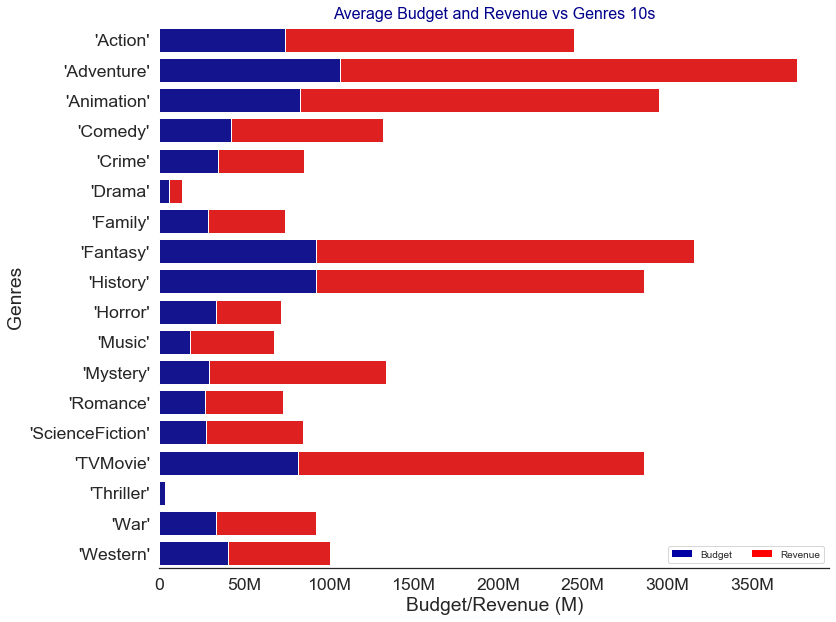

In [57]:
#Plot 1 - background - "total" (top) series

sns.barplot(x=  new_decade_data[4]['movie_revenue'], y= new_decade_data[0]['genre_explode'], color = "red")
 
#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = new_decade_data[4]['movie_budget'], y= new_decade_data[0]['genre_explode'], color = "#0000A3")
bottom_plot.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
# bottom_plot.set_xticklabels(bottom_plot.get_xticklabels(),rotation=45)
topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='#0000A3',  edgecolor = 'none')
plt.legend([bottombar, topbar], ['Budget', 'Revenue'], loc=4, ncol = 2, prop={'size':10})
l.draw_frame(False)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_xlabel("Budget/Revenue (M)")
bottom_plot.set_ylabel("Genres")
bottom_plot.set_title('Average Budget and Revenue vs Genres 10s' , fontsize = 16, color = 'darkblue')

## Answer #3

- On average, the top 3 grossing genres over the last four decades were **Adventure, Fantasy, and Animation.** 

- Low risk investment genres such **Comedy and Romance** will still give you a good return on investment. 

- Movie genres to avoid are **Thrillers and Dramas** which have been very low grossing over the last four decades.

## Conclusion

- In conclusion, my recommendations for microsoft would be to focus on the genres that capture the most audience which would in turn bring in the most revenue. Yes, the budgets are alot higher but with historical data we are able to prove that there is a more success rate with theses genres which means a higher initial investment. 

- A good genre/rating pair: PG-13/Animation film

- A bad genre/rating pair: R rated/Fantasy film.

- Although "Fantasy" was one of the genres chosen as higher probabililty for success, R rated movies just do not capture a big enough audience because of its viewing restrictions. This in turn will limit the amount of revenue you may be able to generate worldwide.

- Remember, low risk investment movie genres to also purse are Comedy and Romance and **Please stay away from are Thrillers and Dramas.** 

## Future Work

- Find out which movie studios have been producing more successful genre/rating pairs.

- Identity highest grossing actors to cast in the first movie.